In [40]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import time
from matplotlib import pyplot as plt
import numpy as np
from backends.fock import Fock
from backends.permanent import Permanent
from backends.xanadu import Xanadu
from backends.quandela import Quandela

In [41]:
backend_list = [Fock, Permanent, Xanadu, Quandela]
backend_names = [str(backend.__name__) for backend in backend_list]

n_runs = 10
max_wires = 6

def generate_bs_wire_list(n_wires):
    """Symmetric MMI"""
    if n_wires % 2 != 0 or n_wires < 1:
        return None
    bs_wire_list = []
    for wire in range(n_wires):
        if wire % 2 == 0:
            bs_wire_list.append([wire + 1, wire + 2])
    for wire in range(n_wires):
        if wire % 2 == 1 and wire != n_wires - 1:
            bs_wire_list.append([wire + 1, wire + 2])

    if n_wires > 2:
        bs_wire_list.append([1, n_wires])

    return bs_wire_list

In [42]:
runtimes = np.zeros((len(backend_list), int(max_wires/2)))
n_wires_list = list(range(2, max_wires + 1, 2))
for wire_idx, n_wires in enumerate(n_wires_list):
    bs_wire_list = generate_bs_wire_list(n_wires)
    for idx, backend in enumerate(backend_list):
        if backend == Xanadu and n_wires > 4:
            runtimes[idx, wire_idx] = np.nan
        else:
            start_time = time.time()
            for n in range(n_runs):
                circuit = backend(n_wires = n_wires, n_photons = n_wires)
                circuit.set_input_state([1] + [0]*(n_wires-1))
                for bs_wires in bs_wire_list:
                    circuit.add_beamsplitter(wires = bs_wires)
                circuit.run()
            runtimes[idx, wire_idx] = time.time() - start_time

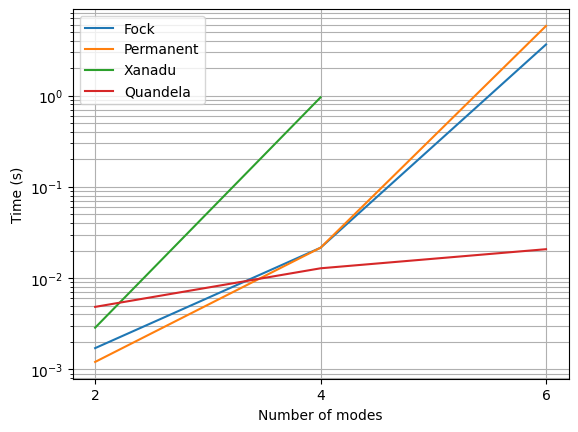

In [43]:
for idx, backend in enumerate(backend_list):
    plt.semilogy(n_wires_list, runtimes[idx, :], label=backend.__name__)
plt.xlabel("Number of modes")
plt.ylabel("Time (s)")
plt.xticks(n_wires_list)
plt.legend()
plt.grid(True, which="both")